### Setup Environment:

In [1]:
import os
from src.selfsupervised import train_byol, get_augmentations
from src.byol import BYOL
import pandas as pd

from src.get_dataset import get_dataset, split_data
from src.data_loader import BRSETDataset, process_labels, SSLDataset
from src.model import FoundationalCVModel, FoundationalCVModelWithClassifier
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

# loss function and optimizer
from src.FocalLoss import FocalLoss

# train and test functions
from src.train import train
from src.test import test

In [2]:
# Constants:
DATASET = '/home/opc/Retina/BRSET/'
DOWNLOAD = False
SHAPE = (224, 224)
IMAGES = os.path.join(DATASET, 'images/')
LABEL = 'DR_ICDR'
TEST_SIZE = 0.2
TEST_SIZE_SSL = 0.4
UNDERSAMPLE = False

LABELS_PATH = os.path.join(DATASET, 'test_ssl.csv')
LABELS_SSL = os.path.join(DATASET, 'train_ssl.csv')
IMAGE_COL = 'image_id'

"""
Dataset Mean and Std:
NORM_MEAN = [0.5896205017400412, 0.29888971649817453, 0.1107679405196557]
NORM_STD = [0.28544273712830986, 0.15905456049750208, 0.07012281660980953]

ImageNet Mean and Std:
NORM_MEAN = [0.485, 0.456, 0.406]
NORM_STD = [0.229, 0.224, 0.225]
"""

NORM_MEAN = None # [0.485, 0.456, 0.406]
NORM_STD = None # [0.229, 0.224, 0.225]

BACKBONE = 'convnextv2_base'
MODE = 'fine_tune'
backbone_mode = 'fine_tune'

HIDDEN = [128]
num_classes = 2

BATCH_SIZE = 16
BATCH_SIZE_SSL = 16
NUM_WORKERS_SSL = 1
NUM_WORKERS = 4

LOSS = None #'focal_loss'
OPTIMIZER = 'adam'

# Define your hyperparameters
num_epochs = 50
learning_rate = 1e-5

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#### Read csv file:

In [3]:
def create_ssl_train_test_split(path, download=False, test_size=0.4, random_state=0):
    df = get_dataset(path, download=download, info=False)
    # Split dataset into train, test and validation:
    df_train, df_test = train_test_split(df, test_size=test_size, random_state=random_state)
    df_train.to_csv(os.path.join(path, 'train_ssl.csv'), index=False)
    df_test.to_csv(os.path.join(path, 'test_ssl.csv'), index=False)
    print('Done!')

#create_ssl_train_test_split(DATASET, download=DOWNLOAD, test_size=TEST_SIZE_SSL)    

# Train Self-supervised BYOL model on BRSET

In [4]:
df = pd.read_csv(LABELS_SSL)
df.head()

,image_id,patient_id,camera,patient_age,comorbidities,diabetes_time_y,insuline,patient_sex,exam_eye,diabetes,...,vascular_occlusion,hypertensive_retinopathy,drusens,hemorrhage,retinal_detachment,myopic_fundus,increased_cup_disc,other,quality,normality
0,img07640,4013,Canon CR,71.0,0,NaN,NaN,1,1,no,...,0,0,0,0,0,0,0,0,Adequate,normal
1,img04988,2634,Canon CR,60.0,"diabetes, SAH",NaN,no,2,2,yes,...,0,0,0,0,0,0,1,0,Adequate,abnormal
2,img10232,5370,Canon CR,55.0,SAH,NaN,NaN,1,1,no,...,0,0,0,0,0,0,0,0,Adequate,normal
3,img09978,5237,Canon CR,78.0,"diabetes, SAH",20,yes,1,2,yes,...,0,0,0,0,0,0,1,0,Adequate,abnormal
4,img03165,1679,Canon CR,71.0,"SAH, hypothyroidism",NaN,NaN,2,2,no,...,0,0,0,0,0,0,1,0,Inadequate,abnormal


In [5]:
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Datasets
train_df, eval_df = train_test_split(df, test_size=0.2, random_state=0)

train_dataset = SSLDataset(train_df, IMAGE_COL, IMAGES, shape=SHAPE, transform=get_augmentations(SHAPE))
eval_dataset = SSLDataset(eval_df, IMAGE_COL, IMAGES, shape=SHAPE, transform=get_augmentations(SHAPE))

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE_SSL, shuffle=True, num_workers=NUM_WORKERS_SSL)
eval_loader = DataLoader(eval_dataset, batch_size=8, shuffle=False, num_workers=NUM_WORKERS_SSL)

In [6]:
# BYOL Model
backbone_model = FoundationalCVModel(backbone=BACKBONE, mode='fine_tune')
byol_model = BYOL(backbone=backbone_model)

byol_model.to(device)

# Use DataParallel to parallelize the model across multiple GPUs
if torch.cuda.device_count() > 1:
    print("Using", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(byol_model, [0,1])

Using 2 GPUs!


In [7]:
# Optimizer
optimizer = torch.optim.Adam(byol_model.parameters(), lr=learning_rate)

# Train
train_byol(byol_model, train_loader, eval_loader, num_epochs, optimizer, device, patience=10, path=f'Models/checkpoint_{BACKBONE}_byol.pt')

100%|██████████| 244/244 [04:33<00:00,  1.12s/it]


Validation loss decreased (inf --> 0.875943).  Saving model ...
Epoch 1, Training Loss: 1.0207642949506885, Validation Loss: 0.8759429523202239


100%|██████████| 244/244 [04:28<00:00,  1.10s/it]


Validation loss decreased (0.875943 --> 0.830018).  Saving model ...
Epoch 2, Training Loss: 0.6565887292877572, Validation Loss: 0.8300176018574199


100%|██████████| 244/244 [04:22<00:00,  1.07s/it]


EarlyStopping counter: 1 out of 10
Epoch 3, Training Loss: 0.7489566409685573, Validation Loss: 0.8391300537547127


100%|██████████| 244/244 [04:27<00:00,  1.10s/it]


Validation loss decreased (0.830018 --> 0.665303).  Saving model ...
Epoch 4, Training Loss: 0.7480310958917024, Validation Loss: 0.6653032771876601


100%|██████████| 244/244 [04:32<00:00,  1.12s/it]


Validation loss decreased (0.665303 --> 0.538863).  Saving model ...
Epoch 5, Training Loss: 0.5991754077497076, Validation Loss: 0.538863186464935


100%|██████████| 244/244 [04:27<00:00,  1.10s/it]


Validation loss decreased (0.538863 --> 0.502974).  Saving model ...
Epoch 6, Training Loss: 0.5256780491012042, Validation Loss: 0.5029739874308227


100%|██████████| 244/244 [04:27<00:00,  1.10s/it]


Validation loss decreased (0.502974 --> 0.426814).  Saving model ...
Epoch 7, Training Loss: 0.4640465483802264, Validation Loss: 0.42681358241644063


100%|██████████| 244/244 [04:35<00:00,  1.13s/it]


Validation loss decreased (0.426814 --> 0.340691).  Saving model ...
Epoch 8, Training Loss: 0.3645339703462163, Validation Loss: 0.34069088199099556


100%|██████████| 244/244 [04:28<00:00,  1.10s/it]


Validation loss decreased (0.340691 --> 0.292823).  Saving model ...
Epoch 9, Training Loss: 0.3066650502017287, Validation Loss: 0.29282275477393727


100%|██████████| 244/244 [04:27<00:00,  1.10s/it]


Validation loss decreased (0.292823 --> 0.240993).  Saving model ...
Epoch 10, Training Loss: 0.2541904735272048, Validation Loss: 0.24099269069609094


100%|██████████| 244/244 [04:20<00:00,  1.07s/it]


Validation loss decreased (0.240993 --> 0.234259).  Saving model ...
Epoch 11, Training Loss: 0.22717253228680032, Validation Loss: 0.2342585877316897


100%|██████████| 244/244 [04:26<00:00,  1.09s/it]


EarlyStopping counter: 1 out of 10
Epoch 12, Training Loss: 0.20873128928121973, Validation Loss: 0.23673749507450667


100%|██████████| 244/244 [04:18<00:00,  1.06s/it]


EarlyStopping counter: 2 out of 10
Epoch 13, Training Loss: 0.21707053360391837, Validation Loss: 0.2350019519446326


100%|██████████| 244/244 [04:36<00:00,  1.14s/it]


Validation loss decreased (0.234259 --> 0.207601).  Saving model ...
Epoch 14, Training Loss: 0.19394052101940404, Validation Loss: 0.20760089110155575


100%|██████████| 244/244 [04:28<00:00,  1.10s/it]


EarlyStopping counter: 1 out of 10
Epoch 15, Training Loss: 0.20112819212381958, Validation Loss: 0.21547573609430282


100%|██████████| 244/244 [04:25<00:00,  1.09s/it]


EarlyStopping counter: 2 out of 10
Epoch 16, Training Loss: 0.18633402542012636, Validation Loss: 0.24258435065629053


100%|██████████| 244/244 [04:31<00:00,  1.11s/it]


Validation loss decreased (0.207601 --> 0.193278).  Saving model ...
Epoch 17, Training Loss: 0.17346861934075591, Validation Loss: 0.19327827164384184


100%|██████████| 244/244 [04:23<00:00,  1.08s/it]


Validation loss decreased (0.193278 --> 0.156959).  Saving model ...
Epoch 18, Training Loss: 0.15317268278755125, Validation Loss: 0.15695923029399309


100%|██████████| 244/244 [04:26<00:00,  1.09s/it]


EarlyStopping counter: 1 out of 10
Epoch 19, Training Loss: 0.15463865780439534, Validation Loss: 0.1697078137124171


100%|██████████| 244/244 [04:22<00:00,  1.07s/it]


Validation loss decreased (0.156959 --> 0.145152).  Saving model ...
Epoch 20, Training Loss: 0.15300828951304077, Validation Loss: 0.14515225662559758


100%|██████████| 244/244 [04:33<00:00,  1.12s/it]


EarlyStopping counter: 1 out of 10
Epoch 21, Training Loss: 0.1477990502216777, Validation Loss: 0.15497329147135624


100%|██████████| 244/244 [04:21<00:00,  1.07s/it]


EarlyStopping counter: 2 out of 10
Epoch 22, Training Loss: 0.1401543844430173, Validation Loss: 0.15296111145957572


100%|██████████| 244/244 [04:23<00:00,  1.08s/it]


EarlyStopping counter: 3 out of 10
Epoch 23, Training Loss: 0.13244292433144617, Validation Loss: 0.19520752693785995


100%|██████████| 244/244 [04:36<00:00,  1.13s/it]


Validation loss decreased (0.145152 --> 0.142296).  Saving model ...
Epoch 24, Training Loss: 0.1365907580637541, Validation Loss: 0.1422957543466912


100%|██████████| 244/244 [04:24<00:00,  1.08s/it]


EarlyStopping counter: 1 out of 10
Epoch 25, Training Loss: 0.12522472319055777, Validation Loss: 0.14595053625888513


100%|██████████| 244/244 [04:31<00:00,  1.11s/it]


Validation loss decreased (0.142296 --> 0.130252).  Saving model ...
Epoch 26, Training Loss: 0.12756599779011774, Validation Loss: 0.1302523021815253


100%|██████████| 244/244 [04:30<00:00,  1.11s/it]


EarlyStopping counter: 1 out of 10
Epoch 27, Training Loss: 0.1206484417446324, Validation Loss: 0.130660995596745


100%|██████████| 244/244 [04:28<00:00,  1.10s/it]


EarlyStopping counter: 2 out of 10
Epoch 28, Training Loss: 0.12720714680484083, Validation Loss: 0.15620210913361096


100%|██████████| 244/244 [04:31<00:00,  1.11s/it]


EarlyStopping counter: 3 out of 10
Epoch 29, Training Loss: 0.13544984625988318, Validation Loss: 0.14804679741624927


100%|██████████| 244/244 [04:29<00:00,  1.10s/it]


Validation loss decreased (0.130252 --> 0.129708).  Saving model ...
Epoch 30, Training Loss: 0.1270483551455326, Validation Loss: 0.1297078567450164


100%|██████████| 244/244 [04:35<00:00,  1.13s/it]


Validation loss decreased (0.129708 --> 0.129602).  Saving model ...
Epoch 31, Training Loss: 0.11511811125473898, Validation Loss: 0.12960240244865417


100%|██████████| 244/244 [04:34<00:00,  1.13s/it]


EarlyStopping counter: 1 out of 10
Epoch 32, Training Loss: 0.1104625009122442, Validation Loss: 0.14267560839653015


100%|██████████| 244/244 [04:34<00:00,  1.12s/it]


EarlyStopping counter: 2 out of 10
Epoch 33, Training Loss: 0.11893569299432098, Validation Loss: 0.143213368341571


100%|██████████| 244/244 [04:31<00:00,  1.11s/it]


EarlyStopping counter: 3 out of 10
Epoch 34, Training Loss: 0.1307572781062517, Validation Loss: 0.14786537504587016


100%|██████████| 244/244 [04:33<00:00,  1.12s/it]


EarlyStopping counter: 4 out of 10
Epoch 35, Training Loss: 0.12197236325897154, Validation Loss: 0.13734763225571053


100%|██████████| 244/244 [04:24<00:00,  1.08s/it]


EarlyStopping counter: 5 out of 10
Epoch 36, Training Loss: 0.13427976897505464, Validation Loss: 0.1443551041063715


100%|██████████| 244/244 [04:32<00:00,  1.12s/it]


EarlyStopping counter: 6 out of 10
Epoch 37, Training Loss: 0.12249307822985728, Validation Loss: 0.17326779345997045


100%|██████████| 244/244 [04:34<00:00,  1.12s/it]


EarlyStopping counter: 7 out of 10
Epoch 38, Training Loss: 0.11355162106576513, Validation Loss: 0.13509936117735066


100%|██████████| 244/244 [04:29<00:00,  1.11s/it]


EarlyStopping counter: 8 out of 10
Epoch 39, Training Loss: 0.11355771832778806, Validation Loss: 0.1457613100771044


100%|██████████| 244/244 [04:26<00:00,  1.09s/it]


Validation loss decreased (0.129602 --> 0.122749).  Saving model ...
Epoch 40, Training Loss: 0.11795351764217751, Validation Loss: 0.122748785331601


100%|██████████| 244/244 [04:26<00:00,  1.09s/it]


Validation loss decreased (0.122749 --> 0.117445).  Saving model ...
Epoch 41, Training Loss: 0.11199814862892275, Validation Loss: 0.11744451962533545


100%|██████████| 244/244 [04:29<00:00,  1.10s/it]


EarlyStopping counter: 1 out of 10
Epoch 42, Training Loss: 0.11278361619495955, Validation Loss: 0.1370973235271016


100%|██████████| 244/244 [04:34<00:00,  1.12s/it]


EarlyStopping counter: 2 out of 10
Epoch 43, Training Loss: 0.11461117326236162, Validation Loss: 0.1296614745601279


100%|██████████| 244/244 [04:29<00:00,  1.10s/it]


EarlyStopping counter: 3 out of 10
Epoch 44, Training Loss: 0.11688503989430725, Validation Loss: 0.12367196454376471


100%|██████████| 244/244 [04:26<00:00,  1.09s/it]


EarlyStopping counter: 4 out of 10
Epoch 45, Training Loss: 0.1109655970921282, Validation Loss: 0.14276455171772692


100%|██████████| 244/244 [04:34<00:00,  1.12s/it]


EarlyStopping counter: 5 out of 10
Epoch 46, Training Loss: 0.11822119843764384, Validation Loss: 0.1360170440595658


100%|██████████| 244/244 [04:28<00:00,  1.10s/it]


EarlyStopping counter: 6 out of 10
Epoch 47, Training Loss: 0.11486070322208718, Validation Loss: 0.143264006395809


100%|██████████| 244/244 [04:26<00:00,  1.09s/it]


EarlyStopping counter: 7 out of 10
Epoch 48, Training Loss: 0.10058207492359349, Validation Loss: 0.13533059251113017


100%|██████████| 244/244 [04:29<00:00,  1.10s/it]


Validation loss decreased (0.117445 --> 0.115990).  Saving model ...
Epoch 49, Training Loss: 0.10964068721552364, Validation Loss: 0.11598988830066118


100%|██████████| 244/244 [04:41<00:00,  1.15s/it]


Validation loss decreased (0.115990 --> 0.111650).  Saving model ...
Epoch 50, Training Loss: 0.09963650635031403, Validation Loss: 0.111649894812068


# Downstream task: Image Diabetic Retinopathy Detection

In [8]:
TEST_SIZE = 0.2
df = pd.read_csv(LABELS_PATH)
# Convert into 2 classes:

# Normal = 0; Non-proliferative = 1, 2, 3; Proliferative = 4
# Map values to categories
df[LABEL] = df[LABEL].apply(lambda x: 'Normal' if x == 0 else 'Diabetic Retinopathy')

Train data shape: (5205, 35)
Test data shape: (1302, 35)


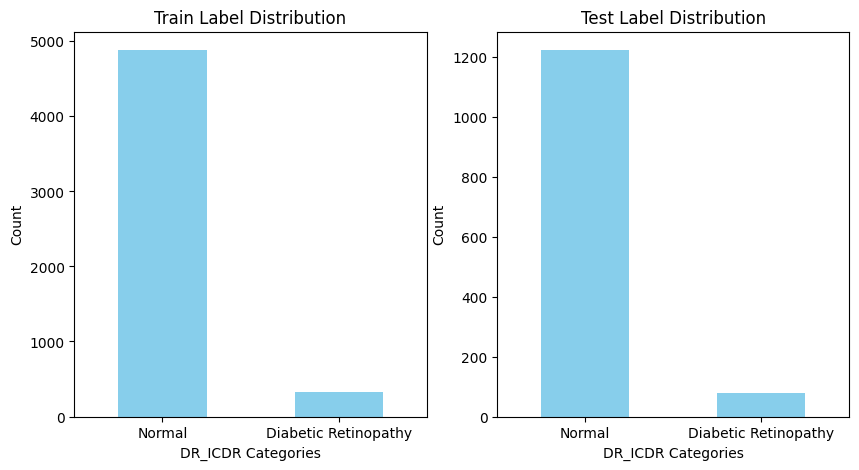

Getting validation set...
Train data shape: (1041, 35)
Test data shape: (261, 35)


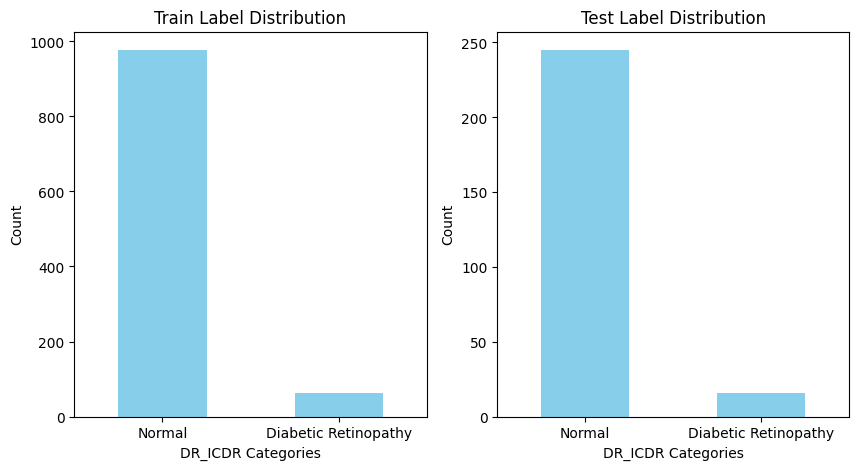

In [9]:
# Split dataset into train, test and validation:
df_train, df_test = split_data(df, LABEL, TEST_SIZE)
print('Getting validation set...')
df_test, df_val = split_data(df_test, LABEL, 0.20)

### Dataloaders

In [10]:
# Train the one hot encoder on the train set and get the labels for the test and validation sets:
train_labels, mlb, train_columns = process_labels(df_train, col=LABEL)

In [11]:
# Define the target image shape
SHAPE = (224, 224)  # Adjust to your desired image size

train_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop(SHAPE),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
    transforms.RandomRotation(50),  # Randomly rotate the image by up to 10 degrees
])

if NORM_MEAN is not None and NORM_STD is not None:
    train_transforms.transforms.append(transforms.Normalize(mean=NORM_MEAN, std=NORM_STD))

test_transform = transforms.Compose([
    transforms.Resize(SHAPE),
    transforms.ToTensor(),
])

if NORM_MEAN is not None and NORM_STD is not None:
    test_transform.transforms.append(transforms.Normalize(mean=NORM_MEAN, std=NORM_STD))


In [12]:
# Create the custom dataset
train_dataset = BRSETDataset(
    df_train, 
    IMAGE_COL, 
    IMAGES, 
    LABEL, 
    mlb, 
    train_columns, 
    transform=train_transforms
)

test_dataset = BRSETDataset(
    df_test, 
    IMAGE_COL, 
    IMAGES, 
    LABEL, 
    mlb, 
    train_columns, 
    transform=test_transform
)

val_dataset = BRSETDataset(
    df_val, 
    IMAGE_COL, 
    IMAGES, 
    LABEL, 
    mlb, 
    train_columns, 
    transform=test_transform
)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

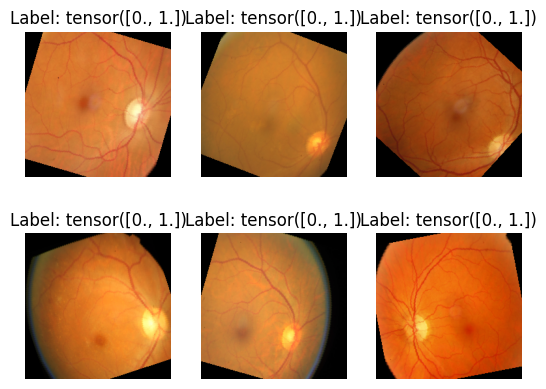

In [13]:
# Print 6 samples with their labels
# Iterate through the DataLoader and plot the images with labels
for batch in train_dataloader:
    images, labels = batch['image'], batch['labels']

    for i in range(len(images)):
        if i == 6:
            break
        plt.subplot(2, 3, i + 1)
        plt.imshow(images[i].permute(1, 2, 0))  # Permute to (H, W, C) from (C, H, W)
        plt.title(f"Label: {labels[i]}")
        plt.axis('off')
    plt.show()
    break

### Model

In [15]:
# Create the model
# backbone_model = FoundationalCVModel(backbone=BACKBONE, mode=MODE)
backbone_model = byol_model.backbone.to("cpu")
model = FoundationalCVModelWithClassifier(backbone_model, hidden=HIDDEN, num_classes=num_classes, mode=MODE, backbone_mode=backbone_mode)
model.to(device)

# Use DataParallel to parallelize the model across multiple GPUs
if torch.cuda.device_count() > 1:
    print("Using", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model, [0,1])

Using 2 GPUs!


### Training:

In [16]:
if LOSS == 'focal_loss':
    class_distribution = train_dataloader.dataset.labels.sum(axis=0)
    print(f'Class distribution: {class_distribution}')
    class_dis = np.array(class_distribution)
    class_weights =1-class_dis/np.sum(class_dis)
    weights = torch.tensor(class_weights).to(device)
    #criterion = FocalLoss()  # Focal Loss
    criterion = FocalLoss(gamma=2, alpha=weights)
else:
    # Assuming train_loader.dataset.labels is a one-hot representation
    class_indices = np.argmax(train_dataloader.dataset.labels, axis=1)

    # Compute class weights using class indices
    class_weights = compute_class_weight('balanced', classes=np.unique(class_indices), y=class_indices)
    class_weights = torch.tensor(class_weights, dtype=torch.float32)
    criterion = nn.CrossEntropyLoss(weight=class_weights).to(device)
    #criterion = nn.BCEWithLogitsLoss() # Binary Cross-Entropy Loss

if OPTIMIZER == 'adam':
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
elif OPTIMIZER == 'adamw':
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
else:
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

In [17]:
model = train(model, train_dataloader, val_dataloader, criterion, optimizer, num_epochs=num_epochs, save=True, device=device, backbone=f'convnextv2_binary_{LABEL}_byol')

  0%|          | 0/326 [00:00<?, ?it/s]

100%|██████████| 17/17 [00:05<00:00,  3.18it/s]


Epoch 1, Train Loss: 0.6469329122019691, Val Loss: 0.5224420515929952, F1 Score: 0.564191811105101


100%|██████████| 17/17 [00:05<00:00,  3.16it/s]


Epoch 2, Train Loss: 0.5323445300108816, Val Loss: 0.4523665957591113, F1 Score: 0.6999540159411405


100%|██████████| 17/17 [00:05<00:00,  3.16it/s]


Epoch 3, Train Loss: 0.5096366991248965, Val Loss: 0.5066317688016331, F1 Score: 0.5972222222222222


100%|██████████| 17/17 [00:05<00:00,  3.18it/s]


Epoch 4, Train Loss: 0.48457758407468443, Val Loss: 0.43968987903174234, F1 Score: 0.728362682652679


100%|██████████| 17/17 [00:05<00:00,  3.19it/s]


Epoch 5, Train Loss: 0.4779002901646623, Val Loss: 0.4540631963926203, F1 Score: 0.7544904815229563


100%|██████████| 17/17 [00:05<00:00,  3.13it/s]


Epoch 6, Train Loss: 0.44766339508850883, Val Loss: 0.3872801416060504, F1 Score: 0.7766260935717002


100%|██████████| 17/17 [00:05<00:00,  3.24it/s]


Epoch 7, Train Loss: 0.46904469868796733, Val Loss: 0.43027660951894875, F1 Score: 0.6987012987012986


100%|██████████| 17/17 [00:05<00:00,  3.23it/s]


Epoch 8, Train Loss: 0.47457116568015395, Val Loss: 0.38289360176114473, F1 Score: 0.7409932260430598


100%|██████████| 17/17 [00:05<00:00,  3.19it/s]


Epoch 9, Train Loss: 0.44860294826922975, Val Loss: 0.47683944509309883, F1 Score: 0.7175324675324676


100%|██████████| 17/17 [00:05<00:00,  3.04it/s]


Epoch 10, Train Loss: 0.41710289086620866, Val Loss: 0.4972733189077938, F1 Score: 0.6821148621217326


100%|██████████| 17/17 [00:05<00:00,  3.21it/s]


Epoch 11, Train Loss: 0.4235843929913512, Val Loss: 0.4398134850403842, F1 Score: 0.7834024896265559


100%|██████████| 17/17 [00:05<00:00,  3.19it/s]


Epoch 12, Train Loss: 0.4067899715955272, Val Loss: 0.9618764449568356, F1 Score: 0.7066316972648932


100%|██████████| 17/17 [00:05<00:00,  3.25it/s]


Epoch 13, Train Loss: 0.396985718409068, Val Loss: 0.5027256976155674, F1 Score: 0.6999540159411405


100%|██████████| 17/17 [00:05<00:00,  3.11it/s]


Epoch 14, Train Loss: 0.39455998789496216, Val Loss: 0.3806537153089748, F1 Score: 0.728362682652679


100%|██████████| 17/17 [00:05<00:00,  3.15it/s]


Epoch 15, Train Loss: 0.4249836241060788, Val Loss: 0.47227463652105894, F1 Score: 0.7246835443037976


100%|██████████| 17/17 [00:05<00:00,  3.17it/s]


Epoch 16, Train Loss: 0.4091721931415284, Val Loss: 0.3007507666068919, F1 Score: 0.8315635083602229


100%|██████████| 17/17 [00:05<00:00,  3.15it/s]


Epoch 17, Train Loss: 0.3748836162288679, Val Loss: 0.3402710793649449, F1 Score: 0.8014806551391918


100%|██████████| 17/17 [00:05<00:00,  3.15it/s]


Epoch 18, Train Loss: 0.35972904045980403, Val Loss: 0.35029902265352364, F1 Score: 0.7750114091577507


100%|██████████| 17/17 [00:05<00:00,  3.19it/s]


Epoch 19, Train Loss: 0.37276315823928713, Val Loss: 0.33145274747820463, F1 Score: 0.7009819967266776


100%|██████████| 17/17 [00:05<00:00,  3.17it/s]


Epoch 20, Train Loss: 0.34322834005750763, Val Loss: 0.3208713535876835, F1 Score: 0.7108262108262109


100%|██████████| 17/17 [00:05<00:00,  3.14it/s]


Epoch 21, Train Loss: 0.3209575527330483, Val Loss: 0.3113837097497547, F1 Score: 0.8013266637668551
Early stopping triggered.


### Test

100%|██████████| 66/66 [00:19<00:00,  3.42it/s]


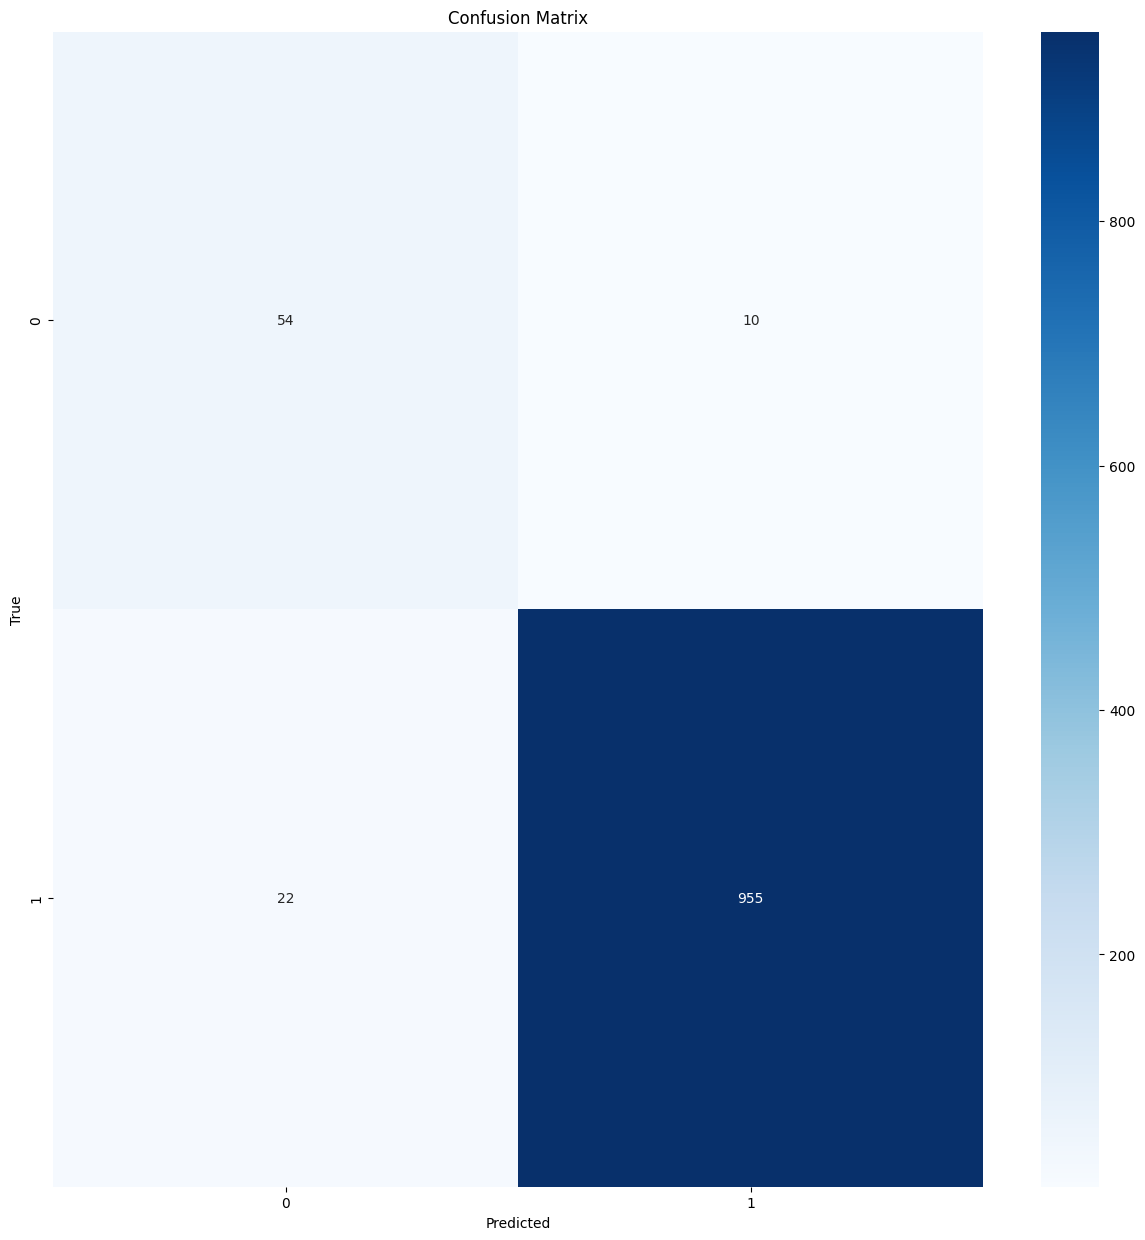

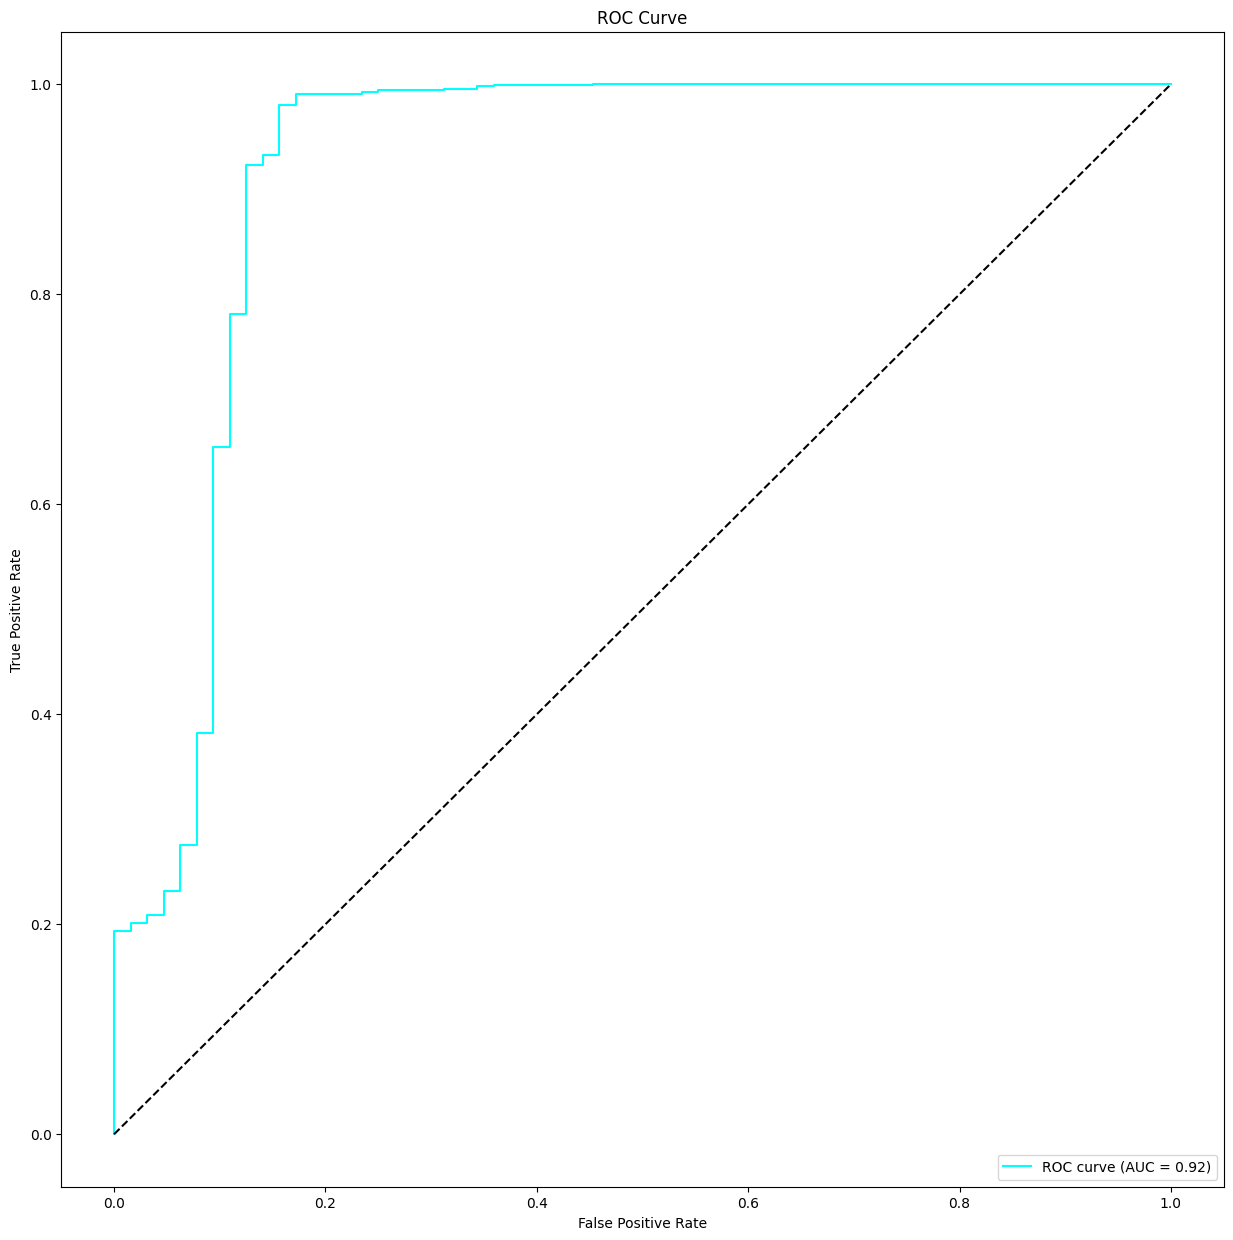

              precision    recall  f1-score   support

           0       0.71      0.84      0.77        64
           1       0.99      0.98      0.98       977

    accuracy                           0.97      1041
   macro avg       0.85      0.91      0.88      1041
weighted avg       0.97      0.97      0.97      1041

##################################################  Saliency Maps  ##################################################

Class 0:


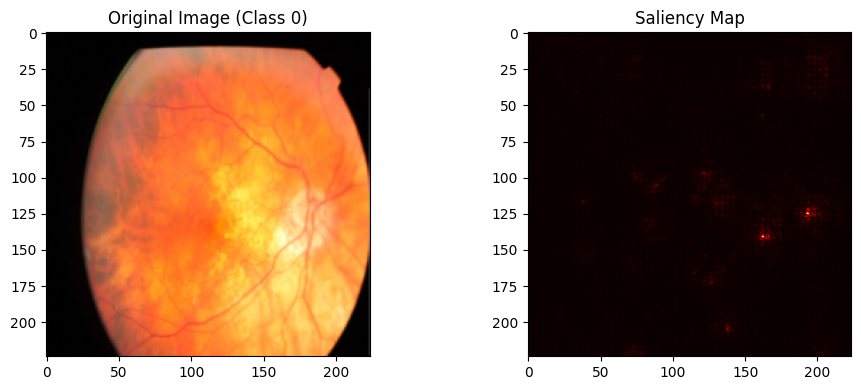

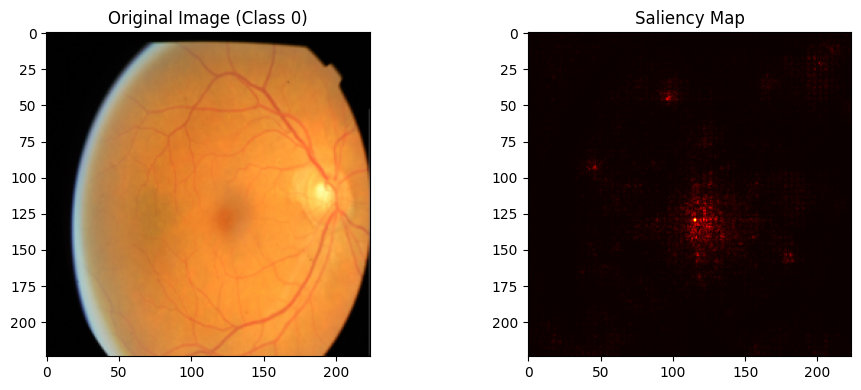

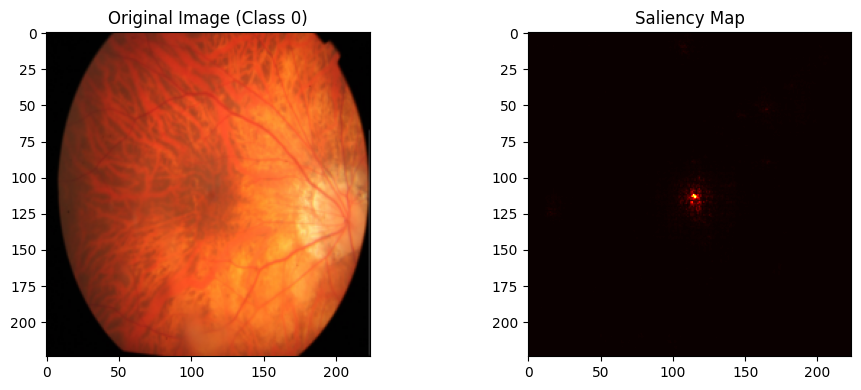

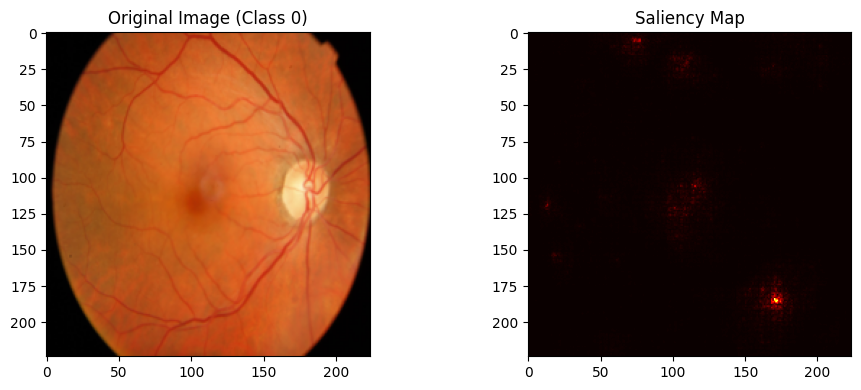

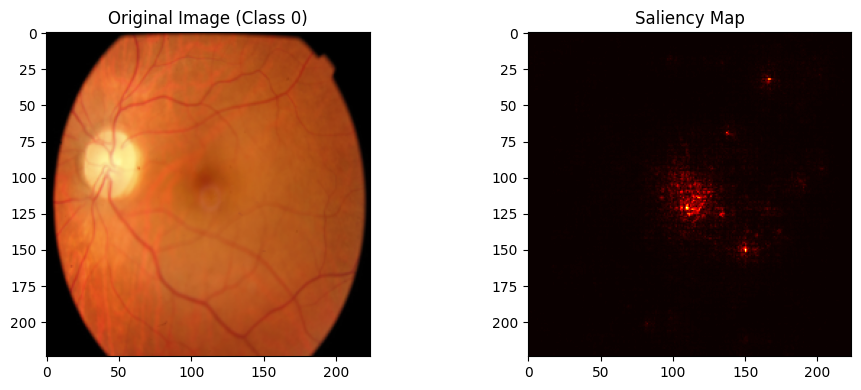

Class 1:


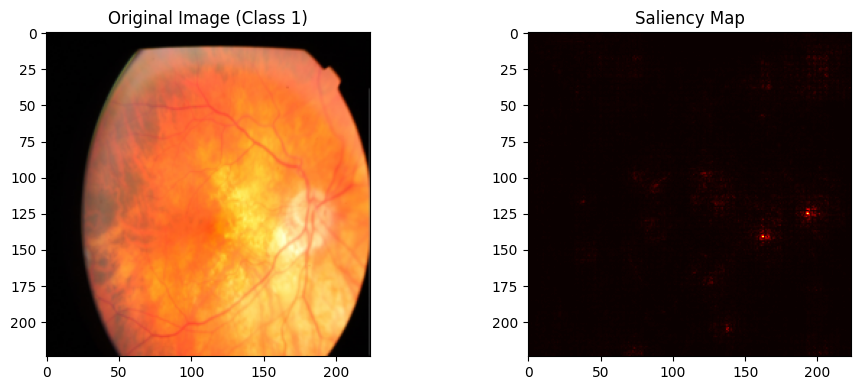

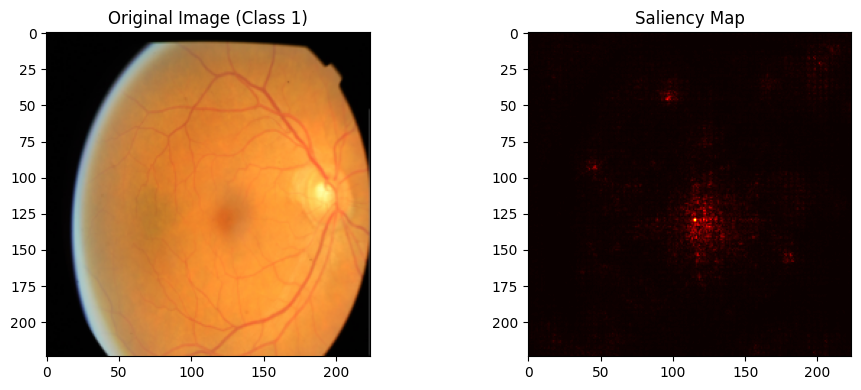

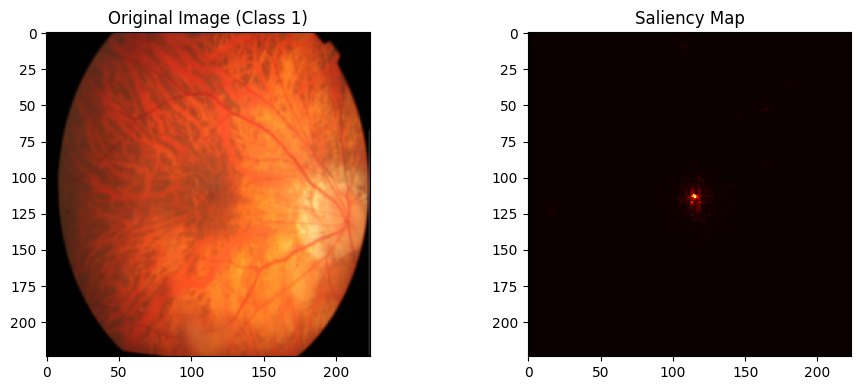

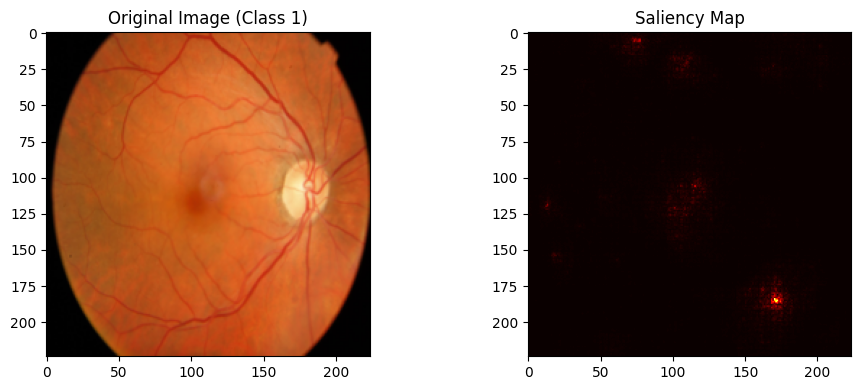

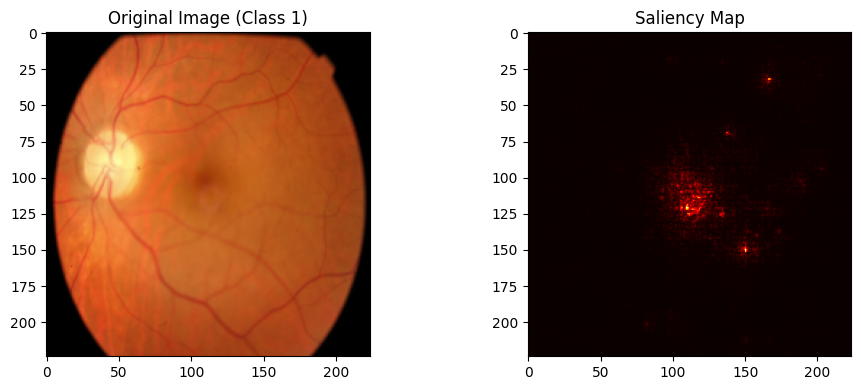

: 

In [18]:
test(model, test_dataloader, saliency=True, device=device)